In [2]:
data_dir_path = '/content/drive/MyDrive/Lung_cancer'

In [3]:
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler
import matplotlib.pyplot as plt
import json
import joblib
import seaborn as sns

target_column = 'Lung Cancer Occurrence'
merged_df = pd.read_csv(f'{data_dir_path}/dataset.csv')

In [5]:
import sklearn
sklearn.__version__

'1.2.2'

In [4]:
joblib.__version__

'1.3.2'

In [ ]:
merged_df.columns

Index(['Age', 'Gender', 'COPD History', 'Genetic Markers',
       'Air Pollution Exposure', 'Last Weight', 'Current Weight',
       'Start Smoking', 'Taken Bronchodilators', 'Frequency of Tiredness',
       'Dominant Hand', 'Lung Cancer Occurrence'],
      dtype='object')

12
['Age', 'Gender', 'COPD History', 'Genetic Markers', 'Air Pollution Exposure', 'Last Weight', 'Current Weight', 'Start Smoking', 'Taken Bronchodilators', 'Frequency of Tiredness', 'Dominant Hand', 'Lung Cancer Occurrence']
Processing started for model RandomForest...
{'params': {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 4]}, 'ohe': True, 'standardize': False}
{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 200}
Processing completed for model RandomForest...
Processing started for model SVM...
{'params': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear', 'poly']}, 'ohe': True, 'standardize': True}
{'C': 10, 'kernel': 'linear'}
Processing completed for model SVM...
Processing started for model KNN...
{'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}, 'ohe': True, 'standardize': True}
{'n_neighbors': 9, 'weights': 'distance'}
Processing completed for model KNN...
Processing started for model LogisticRegression...
{'par

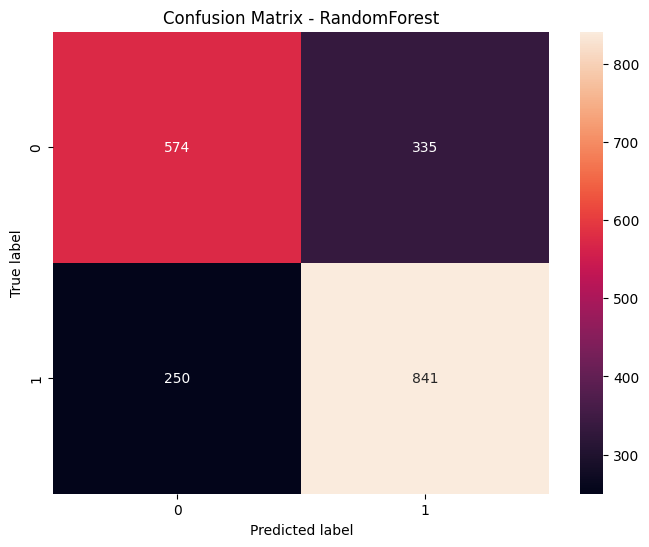

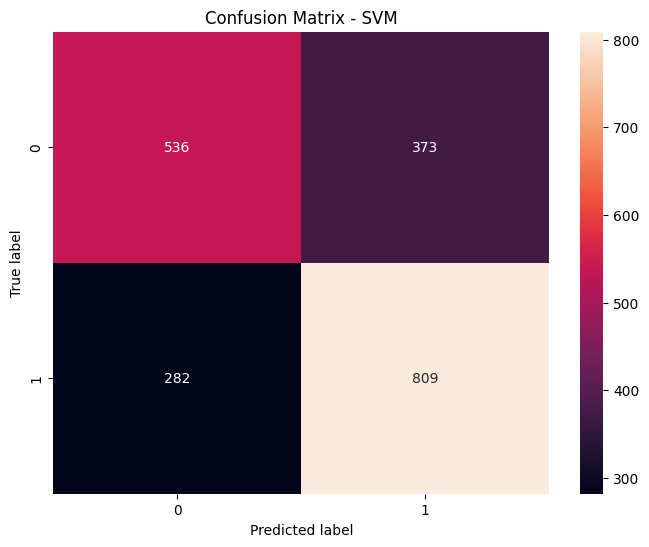

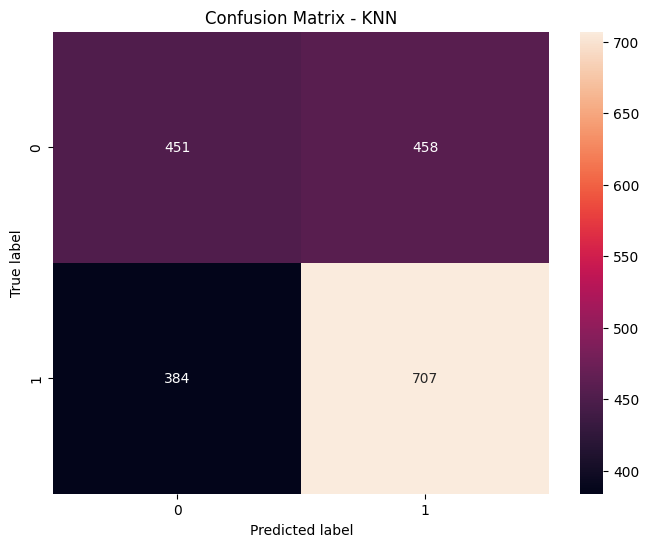

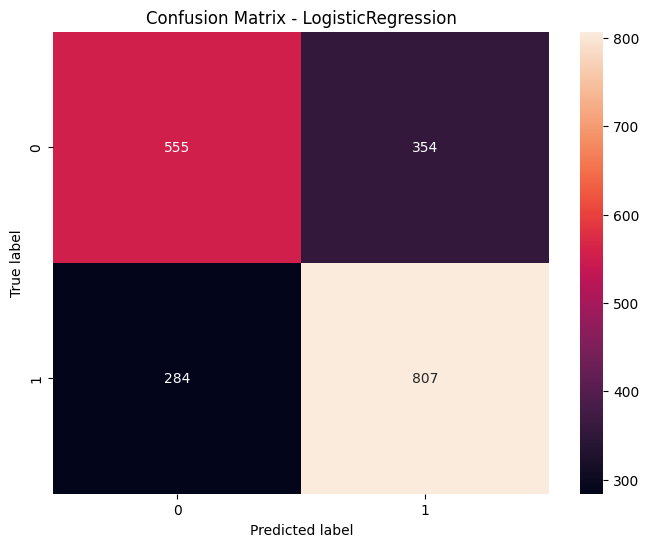

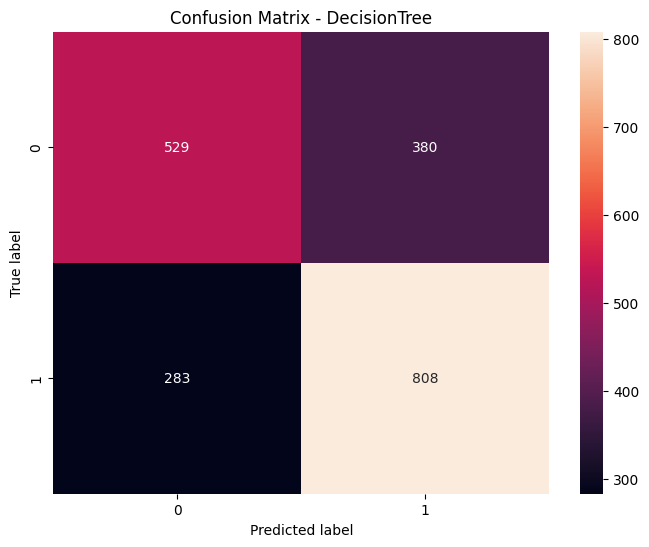

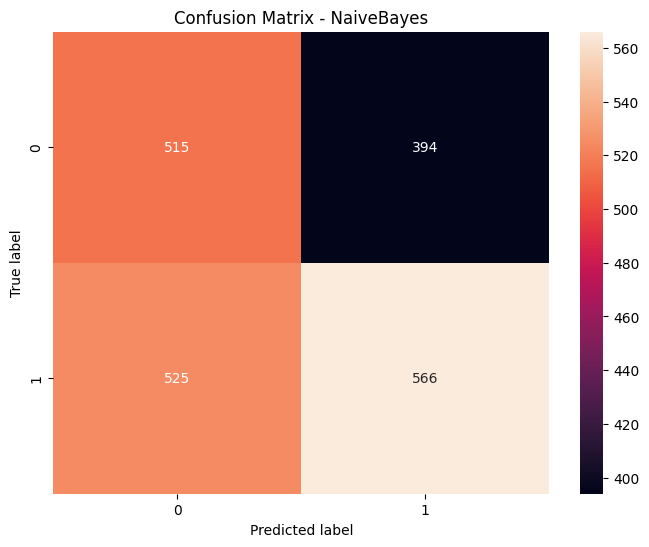

In [ ]:


#merged_df.drop('Unnamed: 0', axis=1, inplace=True)

print(len(merged_df.columns.tolist()))
print(list(merged_df.columns))
X = merged_df.drop(target_column, axis=1)
y = merged_df[target_column]

y_binarized = label_binarize(y, classes=np.unique(y))

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

with open('/content/drive/MyDrive/Lung_cancer/config.json', 'r') as file:
    param_grid = json.load(file)
def apply_ohe(X):
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_encoded = ohe.fit_transform(X[categorical_cols]).toarray()
    joblib.dump(ohe, f'{data_dir_path}/ohe.pkl')
    return pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols))

def apply_standardization(X, X_encoded=None):
    if X_encoded is not None:
        X_numerical = X[numerical_cols].reset_index(drop=True)
        X_combined = pd.concat([X_numerical, X_encoded], axis=1)
    else:
        X_combined = X[numerical_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)
    joblib.dump(scaler, f'{data_dir_path}/scaler.pkl')
    return pd.DataFrame(X_scaled, columns=X_combined.columns)

def get_train_test_data(ohe_required, normalization_required):
    X_processed = X.copy()
    X_encoded = None
    if ohe_required:
        X_encoded = apply_ohe(X)
        X_processed = pd.concat([X[numerical_cols], X_encoded], axis=1)
    if normalization_required:
        X_processed = apply_standardization(X, X_encoded)
    cols = list(X_processed.columns)
    with open(f'{data_dir_path}/features.txt', 'w') as fp:
      fp.write("\n".join(cols))
    return train_test_split(X_processed, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'NaiveBayes': GaussianNB()
}

results = {}




for name, model in models.items():

    print(f'Processing started for model {name}...')
    print(param_grid[name])

    #if not os.path.exists(f'{data_dir_path}/{name}_model.pkl'):
    grid = GridSearchCV(model, param_grid[name]['params'], cv=10, scoring='accuracy', n_jobs=-1)
    X_train, X_test, y_train, y_test = get_train_test_data(param_grid[name]['ohe'], param_grid[name]['standardize'])
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Save the model
    joblib.dump(grid.best_estimator_, f'{data_dir_path}/{name}_model.pkl')


    # Predictions
    y_pred = grid.best_estimator_.predict(X_test)
    #y_pred = np.array(y_pred)
    #y_test = np.array(y_test)


        # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
            'Accuracy': accuracy,
            'Classification Report': class_report,
            'Confusion Matrix': conf_matrix.tolist()
    }

        # Plot and save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{data_dir_path}/{name}_confusion_matrix.png')

    print(f'Processing completed for model {name}...')

# Save results to JSON
with open(f'{data_dir_path}/model_evaluation_results.json', 'w') as file:
    json.dump(results, file, indent=4)


In [ ]:
merged_df.columns

Index(['Gender', 'Source of Traffic', 'Onboard Wifi Service',
       'Embarkation/Disembarkation time convenient', 'Ease of Online booking',
       'Gate location', 'Onboard Dining Service', 'Online Check-in',
       'Cabin Comfort', 'Cabin service', 'Baggage handling',
       'Port Check-in Service', 'Onboard Service', 'Cleanliness',
       'Cruise Name', 'Ticket Type', 'WiFi', 'Dining', 'Entertainment', 'Age',
       'Cruise Distance KM', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')